<a href="https://colab.research.google.com/github/HugoKD/byoRNA/blob/main/Copie_de_ByoRna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random
import math
import numpy as np
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## POO

On va faire un poo en python pour simuler le process de filtration. Chaque filtre possède une certaine affinité, des certaines caractéristiques. On veut arriver à un résultat optimal en un nombre d'étapes minimales -> programation sous contraintes. On veut un nombre de step min et un quantité d'ARN maximale (ou alors une pureté maximale). Pour l'instant on ne considère que la taille de la molécule d'interêt. <br><br>
De base on part d'une population de x% d'ARN,y% ADN, z% débris, w% de protéines, v% de virus et p% de petites molécules -> fixé. La masse totale de la mixture,elle n'est pas fixée. Cf UPS

In [19]:
class USP:
    def __init__(self, mu_max=0.4, K_s=0.9, Y_E=0.8, q_G=0.1, q_O=0.5, m=0.01, G0=20, X0=0.4, E0=0, O0=100):
        self.mu_max = mu_max  # taux de croissance spécifique maximal (h^-1)
        self.K_s = K_s  # constante de saturation de Monod pour le glucose (g/L)
        self.Y_E = Y_E  # yield de l'éthanol sur le glucose (g/g)
        self.q_G = q_G  # taux spécifique de consommation de glucose (g/g.h)
        self.q_O = q_O  # taux spécifique de consommation d'oxygène (%/g.h)
        self.m = m  # taux de maintenance (h^-1)
        # concentrations initiales
        self.G0 = G0  # c_i de glucose (g/L)
        self.X0 = X0  # c_i de biomasse (g/L)
        self.E0 = E0  # c_i d'éthanol (g/L)
        self.O0 = O0  # c_i d'oxygène (%)
        self.solution = None  # Variable pour stocker la solution

    def model(self, y, t):
        G, X, E, O = y
        mu = self.mu_max * (G / (self.K_s + G))
        dG_dt = -mu * X - self.q_G * X
        dX_dt = (mu - self.m) * X
        dE_dt = self.Y_E * (self.q_G - mu) * X
        dO_dt = -self.q_O * X
        return [dG_dt, dX_dt, dE_dt, dO_dt]

    def get_solution(self, t_end=30, n=100, plot=True):
        t = np.linspace(0, t_end, n)  # en heure
        y0 = [self.G0, self.X0, self.E0, self.O0]
        # Résoudre les équa diffs avec odeint
        self.solution = odeint(self.model, y0, t)
        G, X, E, O = self.solution.T
        if plot:
            # Créer le graphique
            plt.figure(figsize=(10, 6))
            plt.plot(t, G, label='Glucose')
            plt.plot(t, X, label='Biomasse')
            plt.plot(t, O, label='Oxygène (%)')
            plt.xlabel('Temps (h)')
            plt.ylabel('Concentration (g/L)')
            plt.title('Modèle de Sonnleitner et Käppeli et de Monod')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
          return G, X, E, O

    def get_masse_X(self, taille):  # taille en L
        if self.solution is None:
            self.get_solution(plot=False)
        G, X, E, O = self.solution.T
        return X[-1] * taille  # return g de biomasse

In [21]:
usp = USP()

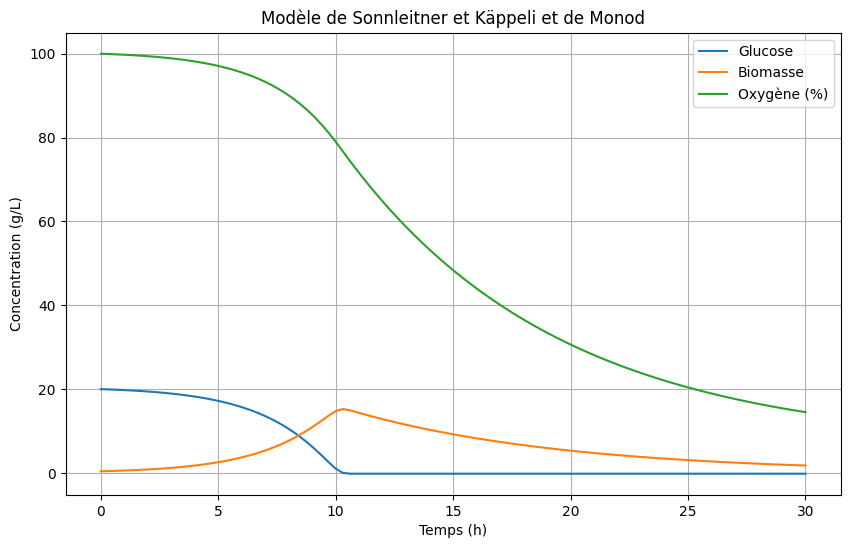

In [22]:
usp.get_solution()

In [23]:
##V.1 simpliste sans considération physique
### Deux comportements différents des filtres basés sur la selectivité des pores : fonction logistique ou fonction de ""passage""" voir si autre loi de passage, plus réaliste

class Filtration:
    def __init__(self, feed,filter_size):
        self.feed = feed #notre mixture qu'on filtre avec x% d'ARN,y% ADN, z% débrit, w% de protéine, v% de virus et p% de petites molécules
        self.filter_size = filter_size #1 seul parametre = taille du filtre, en nm
        self.filtrat = [] #fraction du mélange qui a passé à travers le filtre
        self.residu = [] #fraction du mélange qui n'a pas passé à travers le filtre

    def perform_filtration(self, type_, k_inf = 4.2, c_inf = 1.3,k_sup = 15, c_sup = 1.1): # k = degré de la pente, et c = pnt d'inflexion ou p = 0.5, ajoute d'aléatoire "controlé"
        for molecule in self.feed:
            size = molecule['size']
            r =   size /self.filter_size
            if size <= self.filter_size:
                if type_ == 'logistique':
                 p = 1 / (1 + exp(-k_inf * (c_inf - r))) #fonction logistique avec une forte augmentation de la proba de passer le filtre quand la taille diminue
                elif type_ == 'passage':
                  p = (1 - (size / self.filter_size) ** 2) ** 1
                else :
                  raise(ValueError("Type de filtre inconnu"))
                poids_residu, poids_filtrat = molecule["poids"]*(1-p),molecule["poids"]*p
                mol_filtrat,mol_residu = molecule.copy(),molecule.copy()
                mol_filtrat["poids"] = poids_filtrat
                mol_residu["poids"] = poids_residu
                self.filtrat.append(mol_filtrat)
                self.residu.append(mol_residu)
            else:
                if type_ == 'logistique':
                  p = 1- 1 / (1 + math.exp(-k_sup * (r - c_sup)))  #très forte diminution de la proba de passer le filtre quand la taille augmente
                elif type_ == 'passage':
                  p = 0
                else :
                  raise(ValueError("Type de filtre inconnu"))
                poids_residu, poids_filtrat = molecule["poids"]*(1-p),molecule["poids"]*p
                mol_filtrat,mol_residu =  molecule.copy(),molecule.copy()
                mol_filtrat["poids"] = poids_filtrat
                mol_residu["poids"] = poids_residu
                self.filtrat.append(mol_filtrat)
                self.residu.append(mol_residu)

    def get_results(self):
        return {
            'filtrat': self.filtrat,
            'residu': self.residu
        }

In [24]:
class DSP:
    def __init__(self, feed):
        self.feed = feed

    def get_mean(self, feed):
      s = 0
      for molecule in feed:
        s += molecule['size']
      return s/len(feed)

    def simulate(self, type_,filter_size = 300,display = False):
        # Perform filtration
        filtration = Filtration(self.feed, filter_size=filter_size)
        filtration.perform_filtration(type_)
        filtration_results = filtration.get_results()
        if display :
          print(f"initial : {self.feed}")
          print(f"filtrat: {filtration_results['filtrat']}")
          print(f"residu: {filtration_results['residu']}")
          return self.feed, filtration_results['filtrat'], filtration_results['residu']
        else :
          return self.feed, filtration_results['filtrat'], filtration_results['residu']

    def visu(self,type_,filter_size):
        i,f,r = self.simulate(type_,filter_size)
        data = {'initial' : i, 'filtrat' : f, "residu" : r}
        types = ["DNA", "RNA", "protein", "virus", "tiny_mol", "debris"]
        initial_weights = [item["poids"] for item in data["initial"]]
        filtrat_weights = [item["poids"] for item in data["filtrat"]]
        residu_weights = [next((item["poids"] for item in data["residu"] if item["type"] == t), 0) for t in types]

        # Creating the bar chart
        bar_width = 0.25
        x = np.arange(len(types))

        plt.figure(figsize=(10, 6))
        plt.bar(x - bar_width, initial_weights, width=bar_width, label='Initial')
        plt.bar(x, filtrat_weights, width=bar_width, label='Filtrat')
        plt.bar(x + bar_width, residu_weights, width=bar_width, label='Residu')

        plt.xlabel('Type')
        plt.ylabel('Poids')
        plt.title('Poids par Type pour Initial, Filtrat et Residu')
        plt.xticks(x, types)
        plt.legend()
        plt.show()

masse totale USP de 177.0787413970911


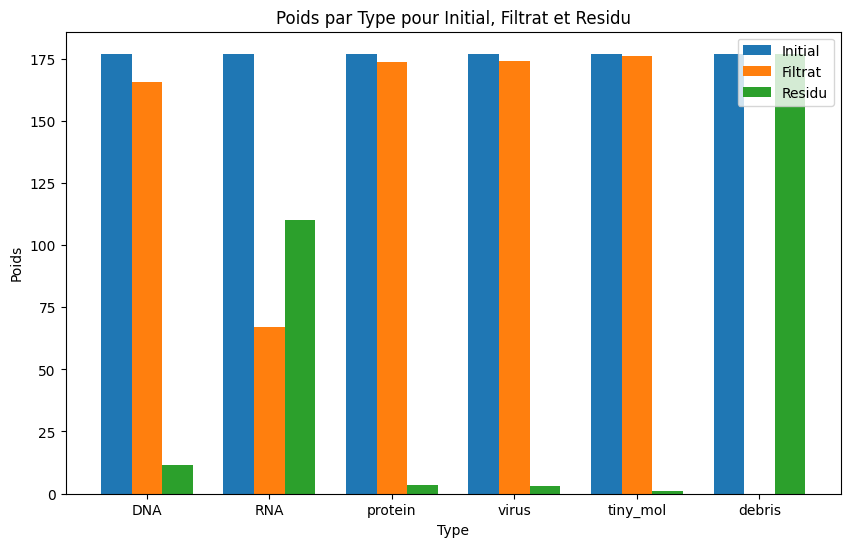

In [25]:
## Test

dalton_to_gram = 1.66e-24

feed = [
    {'type': 'DNA', 'size': 200, 'pourcentage': 0.045, 'poids_unitaire': 200 * 330 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : -1},
    {'type': 'RNA', 'size': 340, 'pourcentage': 0.045, 'poids_unitaire': 340 * 340 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : -1},
    {'type': 'protein', 'size': 108, 'pourcentage': 0.10, 'poids_unitaire': 108 * 110 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : 2},
    {'type': 'virus', 'size': 100, 'pourcentage': 0.01, 'poids_unitaire': 100 * 10**9 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : -1},
    {'type': 'tiny_mol', 'size': 10, 'pourcentage': 0.01, 'poids_unitaire': 1 * 180 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : -1},
    {'type': 'debris', 'size': 1000, 'pourcentage': 0.8, 'poids_unitaire': 200 * 5000 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : 1}
]

print(f"masse totale USP de {usp.get_masse_X(100)}")

filter_size = 300
process = DSP(feed)
process.visu(filter_size= filter_size,type_ = 'logistique')

In [26]:
## Do the same to filter based on the molecule charge
## Chromatographie par echange d ions
## plus la colonne est grande plus la proba de filter une molécule chargée est grande, plus la molécule est chargée plus la proba de la filtrer est grande
filtrat = []
residu = []
def perform_filtration(type_, k_inf = 4.2, c_inf = 1.3,k_sup = 15, c_sup = 1.1): # k = degré de la pente, et c = pnt d'inflexion ou p = 0.5, ajoute d'aléatoire "controlé"
        for molecule in feed:
            size = molecule['size']
            r =   size /filter_size
            if size <= filter_size:
                if type_ == 'logistique':
                 p = 1 / (1 + exp(-k_inf * (c_inf - r))) #fonction logistique avec une forte augmentation de la proba de passer le filtre quand la taille diminue
                elif type_ == 'passage':
                  p = (1 - (size / filter_size) ** 2) ** 1
                else :
                  raise(ValueError("Type de filtre inconnu"))
                poids_residu, poids_filtrat = molecule["poids"]*(1-p),molecule["poids"]*p
                mol_filtrat,mol_residu = molecule.copy(),molecule.copy()
                mol_filtrat["poids"] = poids_filtrat
                mol_residu["poids"] = poids_residu
                filtrat.append(mol_filtrat)
                residu.append(mol_residu)
            else:
                if type_ == 'logistique':
                  p = 1- 1 / (1 + math.exp(-k_sup * (r - c_sup)))  #très forte diminution de la proba de passer le filtre quand la taille augmente
                elif type_ == 'passage':
                  p = 0
                else :
                  raise(ValueError("Type de filtre inconnu"))
                poids_residu, poids_filtrat = molecule["poids"]*(1-p),molecule["poids"]*p
                mol_filtrat,mol_residu =  molecule.copy(),molecule.copy()
                mol_filtrat["poids"] = poids_filtrat
                mol_residu["poids"] = poids_residu
                filtrat.append(mol_filtrat)
                residu.append(mol_residu)
        return filtrat,residu

print(perform_filtration('logistique'))

([{'type': 'DNA', 'size': 200, 'pourcentage': 0.045, 'poids_unitaire': 1.0956e-19, 'poids': 165.50215963567553, 'charge': -1}, {'type': 'RNA', 'size': 340, 'pourcentage': 0.045, 'poids_unitaire': 1.9189600000000002e-19, 'poids': 66.85442645699169, 'charge': -1}, {'type': 'protein', 'size': 108, 'pourcentage': 0.1, 'poids_unitaire': 1.9720800000000002e-20, 'poids': 173.72698332572332, 'charge': 2}, {'type': 'virus', 'size': 100, 'pourcentage': 0.01, 'poids_unitaire': 1.66e-13, 'poids': 174.07609943048968, 'charge': -1}, {'type': 'tiny_mol', 'size': 10, 'pourcentage': 0.01, 'poids_unitaire': 2.988e-22, 'poids': 176.21655718049735, 'charge': -1}, {'type': 'debris', 'size': 1000, 'pourcentage': 0.8, 'poids_unitaire': 1.66e-18, 'poids': 5.111519292638055e-13, 'charge': 1}], [{'type': 'DNA', 'size': 200, 'pourcentage': 0.045, 'poids_unitaire': 1.0956e-19, 'poids': 11.57658176141559, 'charge': -1}, {'type': 'RNA', 'size': 340, 'pourcentage': 0.045, 'poids_unitaire': 1.9189600000000002e-19, 'p

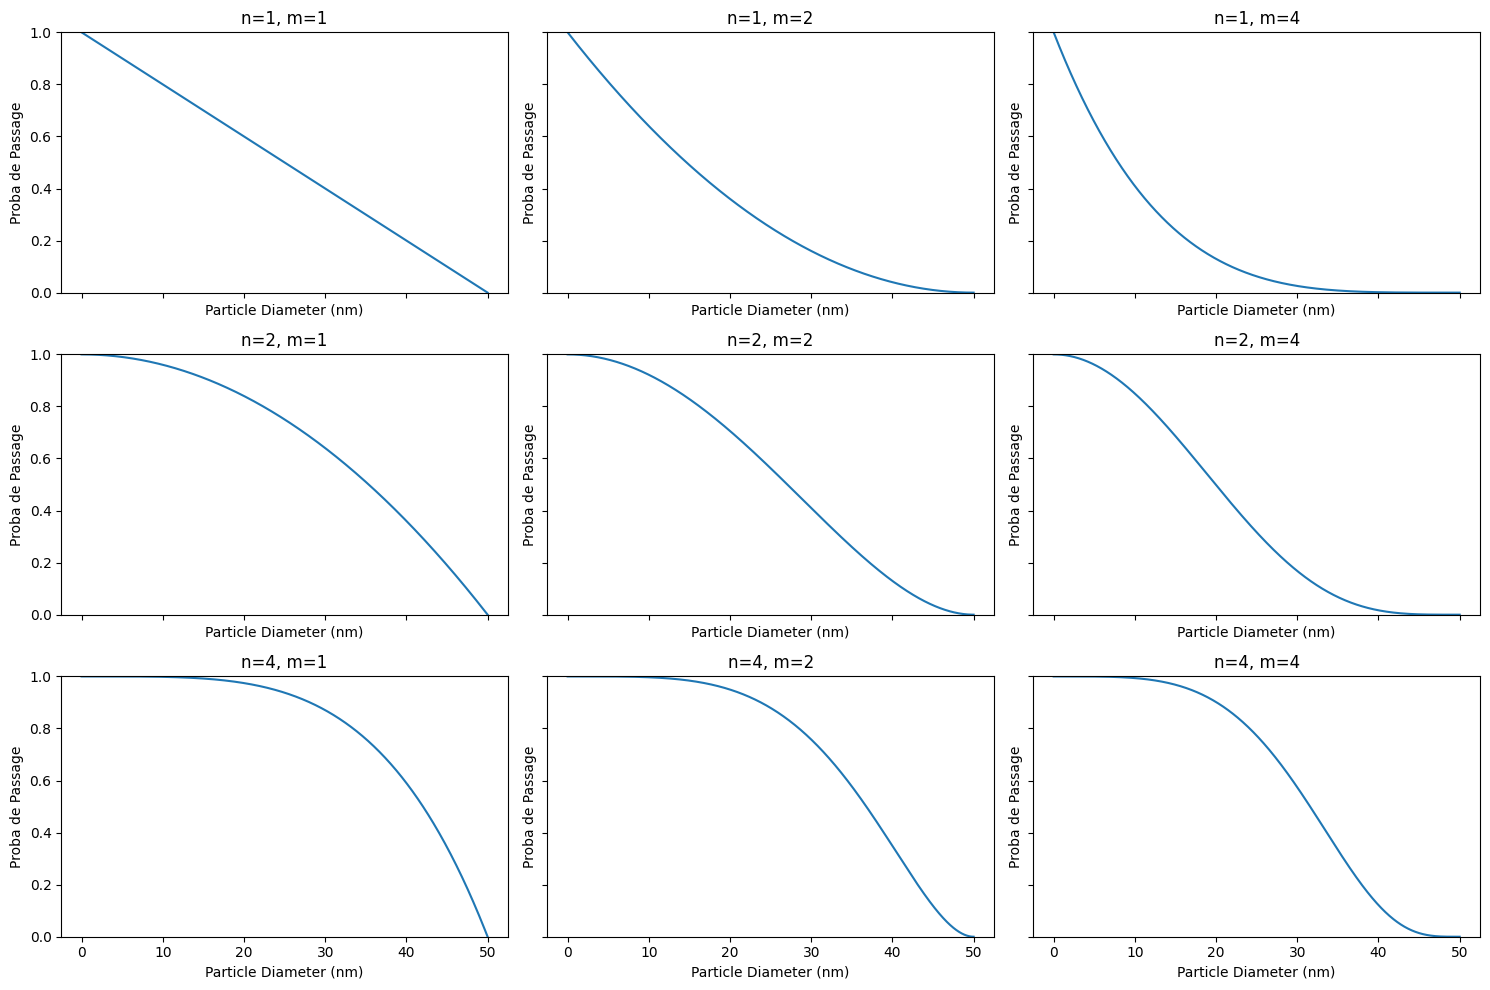

In [27]:
## Influence des paramètres n et m sur la fonction de passage

def passage_probability(pore_diameter, particle_diameter, n, m):
    return (1 - (particle_diameter / pore_diameter) ** n) ** m

pore_diameter = 50  # 50 nm

particle_diameters = np.linspace(0, 50, 1000)  # De 1 nm à 100 nm

# Différentes valeurs de n et m
ns = [1, 2, 4]
ms = [1, 2, 4]

fig, ax = plt.subplots(len(ns), len(ms), figsize=(15, 10), sharex=True, sharey=True)

for i, n in enumerate(ns):
    for j, m in enumerate(ms):
        probabilities = [passage_probability(pore_diameter, d, n, m) for d in particle_diameters]
        ax[i, j].plot(particle_diameters, probabilities)
        ax[i, j].set_title(f'n={n}, m={m}')
        ax[i, j]
        ax[i, j].set_ylim(0, 1)
        ax[i, j].set_xlabel('Particle Diameter (nm)')
        ax[i, j].set_ylabel('Proba de Passage')

plt.tight_layout()
plt.show()


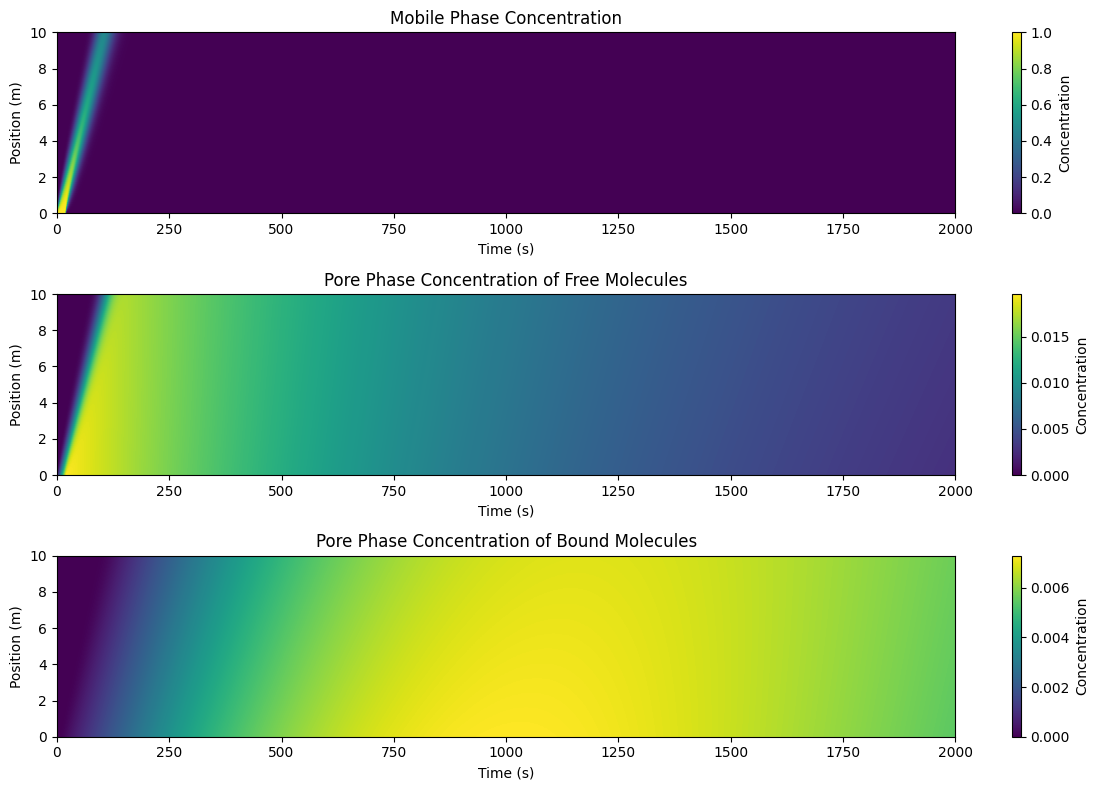

In [36]:
import numpy as np
import matplotlib.pyplot as plt

class Filtration:
    def __init__(self, feed, filter_size):
        self.feed = feed
        self.filter_size = filter_size

class Chromatography(Filtration):
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity):
        super().__init__(feed, filter_size)

        self.L = L # longueur de la colonne (cm)
        self.T = T # temps de la chromatographie
        self.v = v # velocité linéaire de la phase mobile (m/s)
        self.D = D # coefficient de diffusion  (m^2/s)
        self.Nx = Nx # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration # durée d'alimentation
        self.pulse_concentration = pulse_concentration # concentration de l'alimentation
        self.target_molecule = target_molecule # molécule d'interêt
        self.particle_size = particle_size
        self.molecule_size = molecule_size
        self.temperature = temperature
        self.solvent_viscosity = solvent_viscosity
        self.affinity = affinity

        self.z = np.linspace(0, L, Nx)

        # Initialize concentration arrays
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        # Initial conditions
        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        # Transport and production rates
        self.R = self.calculate_R
        self.Rp = self.calculate_Rp
        self.Rq = self.calculate_Rq

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        return self.D * (self.temperature / 298.15) * (1.0 / self.solvent_viscosity)

    def calculate_R(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rp(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rq(self, c, cp, q):
        return self.affinity * (cp - q) * (self.particle_size / (self.particle_size + self.molecule_size))

    def perform_chromatography(self):
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.R(self.c, self.cp, self.q)
            dcp_dt = self.Rp(self.c, self.cp, self.q)
            dq_dt = self.Rq(self.c, self.cp, self.q)

            self.c += dc_dt * self.dt
            self.cp += dcp_dt * self.dt
            self.q += dq_dt * self.dt

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0


            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()

    def plot_results(self,nbr_simu):
        time_points = np.linspace(0, self.T, len(self.c_history))

        size  = self.molecule_size * i * 10
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.title(f'Mobile Phase Concentration for molecule size {size}')
        plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(2, 1, 2)
        plt.title(f'Pore Phase Concentration of Free molecule size {self.charges[i]}')
        plt.imshow(np.array(self.cp_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()


# Parameters
L = 10.0
T = 2000.0
v = 0.1
D = 0.01
Nx = 100
Nt = 100000
pulse_duration = 20
pulse_concentration = 1
target_molecule = 'A'
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0
particle_size = .01  # Example particle size
molecule_size = 0.0001  # Example molecule size
temperature = 298.15  # Example temperature in Kelvin (25°C)
solvent_viscosity = 0.9  # Example solvent viscosity (arbitrary units)
affinity = 0.001  # Example affinity constant
size = [.0001,.001,.01]
# Instantiate and run chromatography
chromatography = Chromatography(L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity)
chromatography.perform_chromatography()
chromatography.plot_result()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class Chromatography():
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_sizes, temperature, solvent_viscosity, affinity):

        self.L = L # longueur de la colonne (cm)
        self.T = T # temps de la chromatographie
        self.v = v # velocité linéaire de la phase mobile (m/s)
        self.D = D # coefficient de diffusion  (m^2/s)
        self.Nx = Nx # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration # durée d'alimentation
        self.pulse_concentration = pulse_concentration # concentration de l'alimentation
        self.target_molecule = target_molecule # molécule d'interêt
        self.particle_size = particle_size
        self.molecule_sizes = molecule_sizes
        self.temperature = temperature
        self.solvent_viscosity = solvent_viscosity
        self.affinity = affinity

        self.z = np.linspace(0, L, Nx)

        # Initialize concentration arrays
        print(self.molecule_sizes)
        print(self.Nx)
        self.c = np.zeros((len(self.molecule_sizes),Nx))
        self.cp = np.zeros((len(self.molecule_sizes),Nx))
        self.q = np.zeros((len(self.molecule_sizes),Nx))

        # Initial conditions
        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        #self.apply_initial_conditions()

        # Transport and production rates
        self.R = self.calculate_R
        self.Rp = self.calculate_Rp
        self.Rq = self.calculate_Rq

        self.c_history = []
        self.cp_history = []
        self.q_history = []

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        return self.D * (self.temperature / 298.15) * (1.0 / self.solvent_viscosity)

    def calculate_R(self, c, cp, q, size):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + size))

    def calculate_Rp(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + size))

    def calculate_Rq(self, c, cp, q):
        return self.affinity * (cp - q) * (self.particle_size / (self.particle_size + size))

    def perform_chromatography(self):
        for n in range(self.Nt):
          for i in range(len(self.molecule_sizes)):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c[i], self.dx)
            N = self.v * self.c[i] + J

            dc_dt = -np.gradient(N, self.dx) - self.R(self.c[i], self.cp[i], self.q[i])
            dcp_dt = self.Rp(self.c[i], self.cp[i], self.q[i])
            dq_dt = self.Rq(self.c[i], self.cp[i], self.q[i])

            self.c[i] += dc_dt * self.dt
            self.cp[i] += dcp_dt * self.dt
            self.q[i] += dq_dt * self.dt

            if t <= self.pulse_duration:
                self.c[i][0] = self.pulse_concentration
            else:
                self.c[i][0] = 0.0


            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def plot_result(self):


        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(np.array(self.cp_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(np.array(self.q_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()

    def plot_results(self,nbr_simu):
        time_points = np.linspace(0, self.T, len(self.c_history))

        for i in range(len(self.molecule_sizes)):

            plt.figure(figsize=(12, 8))
            plt.subplot(2, 1, 1)
            plt.title(f'Mobile Phase Concentration for molecule size {size}')
            plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, slf.T, 0, self.L])
            plt.colorbar(label='Concentration')
            plt.xlabel('Time (s)')
            plt.ylabel('Position (m)')

            plt.subplot(2, 1, 2)
            plt.title(f'Pore Phase Concentration of Free molecule size {self.charges[i]}')
            plt.imshow(np.array(self.cp_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
            plt.colorbar(label='Concentration')
            plt.xlabel('Time (s)')
            plt.ylabel('Position (m)')

            plt.tight_layout()
            plt.show()


# Parameters
L = 10.0
T = 300.0
v = 0.1
D = 0.01
Nx = 100
Nt = 100000
pulse_duration = 5
pulse_concentration = 1
target_molecule = 'A'
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0
particle_size = .01  # Example particle size
molecule_size = 0.0001  # Example molecule size
temperature = 298.15  # Example temperature in Kelvin (25°C)
solvent_viscosity = 0.9  # Example solvent viscosity (arbitrary units)
affinity = 0.001  # Example affinity constant
molecule_sizes = [.0001,.001,.01]
# Instantiate and run chromatography
chromatography = Chromatography(L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_sizes, temperature, solvent_viscosity, affinity)
chromatography.perform_chromatography()
chromatography.plot_results()

[0.0001, 0.001, 0.01]
100


AttributeError: 'Chromatography' object has no attribute 'molecule_size'

(3, 100)


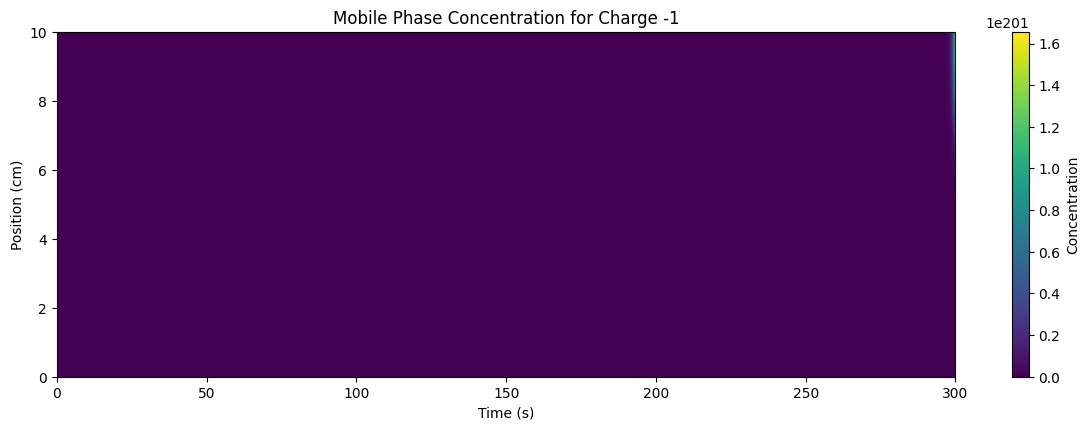

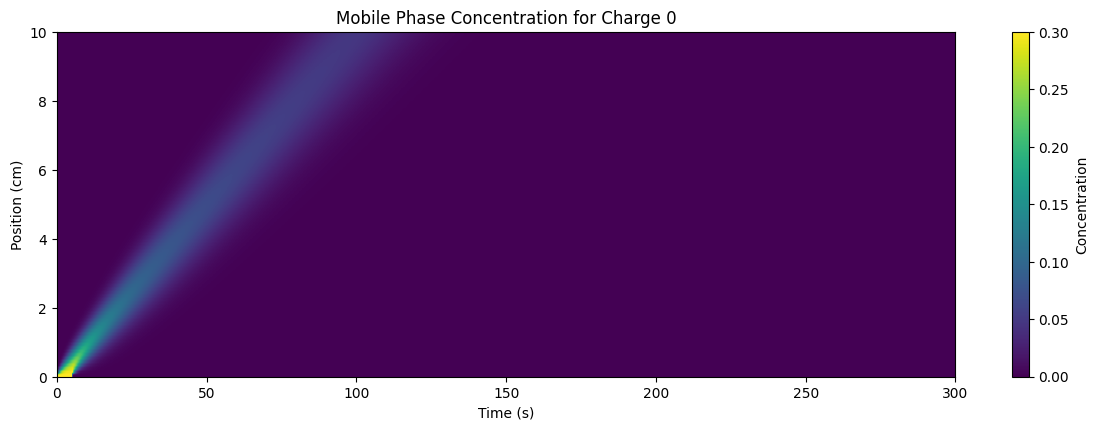

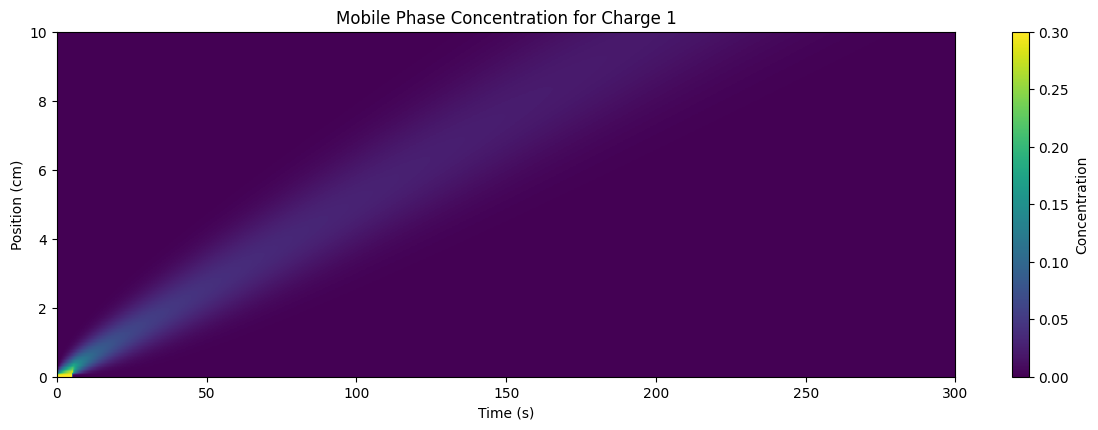

In [ ]:
#faire aussi simu basique
import numpy as np
import matplotlib.pyplot as plt

class ChromatographySimulation:
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, charges, retention_factors):
        self.L = L  # Length of the column
        self.T = T  # Total time
        self.v = v  # Linear mobile phase velocity
        self.D = D  # Diffusion coefficient
        self.Nx = Nx  # Number of spatial grid points
        self.Nt = Nt  # Number of time steps
        self.dx = L / Nx  # Spatial step size
        self.dt = T / Nt  # Time step size
        self.pulse_duration = pulse_duration
        self.pulse_concentration = pulse_concentration
        self.charges = charges  # List of charges of the molecules
        self.retention_factors = retention_factors  # Retention factors for the molecules

        self.c = np.zeros((len(charges), Nx))  # Mobile phase concentration for each molecule
        self.cp = np.zeros((len(charges), Nx))  # Pore phase concentration of free molecules for each molecule

        self.z = np.linspace(0, L, Nx)
        self.c_history = []
        self.cp_history = []

    def R(self, c, cp, charge, retention_factor):
        return  (c - cp) * charge

    def simulate(self):
        for n in range(self.Nt):
            t = n * self.dt
            for i in range(len(self.charges)):
                charge = self.charges[i]
                retention_factor = self.retention_factors[i]

                J = -self.D * np.gradient(self.c[i], self.dx)
                N = self.v * self.c[i] + J

                dc_dt = -np.gradient(N, self.dx) - self.R(self.c[i], self.cp[i], charge, retention_factor)
                dcp_dt = self.R(self.c[i], self.cp[i], charge, retention_factor)

                self.c[i] += dc_dt * self.dt
                self.cp[i] += dcp_dt * self.dt

                if t <= self.pulse_duration:
                    self.c[i][0] = self.pulse_concentration
                else:
                    self.c[i][0] = 0.0

                self.c[i][-1] = self.c[i][-1]

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())

    def plot_results(self):

        time_points = np.linspace(0, self.T, len(self.c_history))

        for i in range(len(self.charges)):
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 1, 1)
            plt.title(f'Mobile Phase Concentration for Charge {self.charges[i]}')
            plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
            plt.colorbar(label='Concentration')
            plt.xlabel('Time (s)')
            plt.ylabel('Position (cm)')

            plt.tight_layout()
            plt.show()

# Parameters
L = 10.0
T = 300.0
v = 0.1
D = 0.01
Nx = 100
Nt = 1000
pulse_duration = 5
pulse_concentration = 0.3
charges = [-1, 0, 1]  # Example charges for different molecules
retention_factors = [0.1, 0.05, 0.2]  # Example retention factors

# Create simulation instance
simulation = ChromatographySimulation(L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, charges, retention_factors)
simulation.simulate()
simulation.plot_results()

## Test

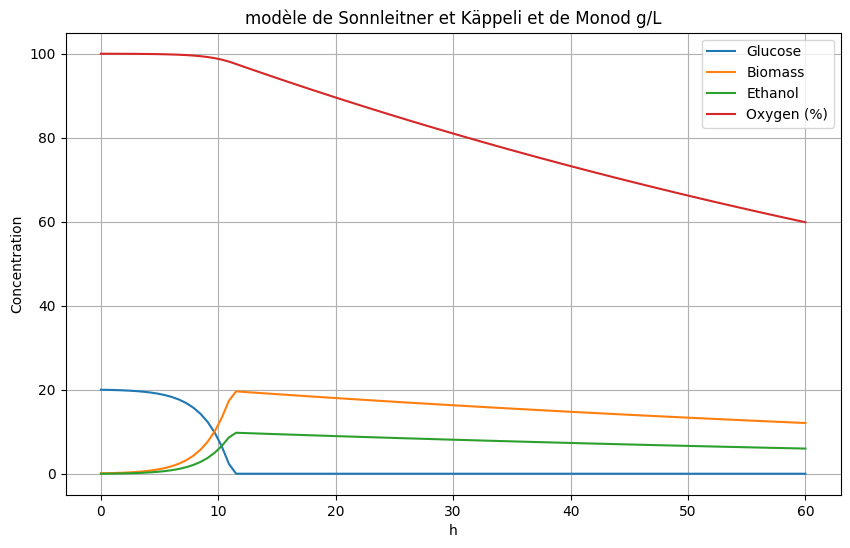

In [ ]:

# Model parameters
mu_max = 0.5  # maximum specific growth rate (h^-1), to know
K_s = 0.5  # Monod constant for glucose (g/L), to know
Y_E = 0.5  # ethanol yield coefficient (g/g)
q_O = 0.05  # specific oxygen consumption rate (%/g.h)
m = 0.01  # maintenance rate (h^-1)

# concentrationes initiales
G0 = 20  #glucose  (g/L)
X0 = 0.1  #  biomass  (g/L)
E0 = 0  #  ethanol  (g/L)
O0 = 100  # oxygen  (%)

#equa diff
def model(y, t):
    G, X, E, O = y
    mu = mu_max * (G / (K_s + G))
    dG_dt = -mu * X
    dX_dt = (mu - m) * X
    dE_dt = Y_E * (mu - m) * X
    dO_dt = -q_O * X
    return [dG_dt, dX_dt, dE_dt, dO_dt]

# Simulation time (hours)
time = np.linspace(0, 60, 100)

# Initial conditions
y0 = [G0, X0, E0, O0]

# Solve the differential equations
solution = odeint(model, y0, time)
G, X, E, O = solution.T

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time, G, label='Glucose')
plt.plot(time, X, label='Biomass')
plt.plot(time, E, label='Ethanol')
plt.plot(time, O, label='Oxygen (%)')

plt.xlabel('h')
plt.ylabel('Concentration')
plt.title('modèle de Sonnleitner et Käppeli et de Monod g/L')
plt.legend()
plt.grid(True)
plt.show()

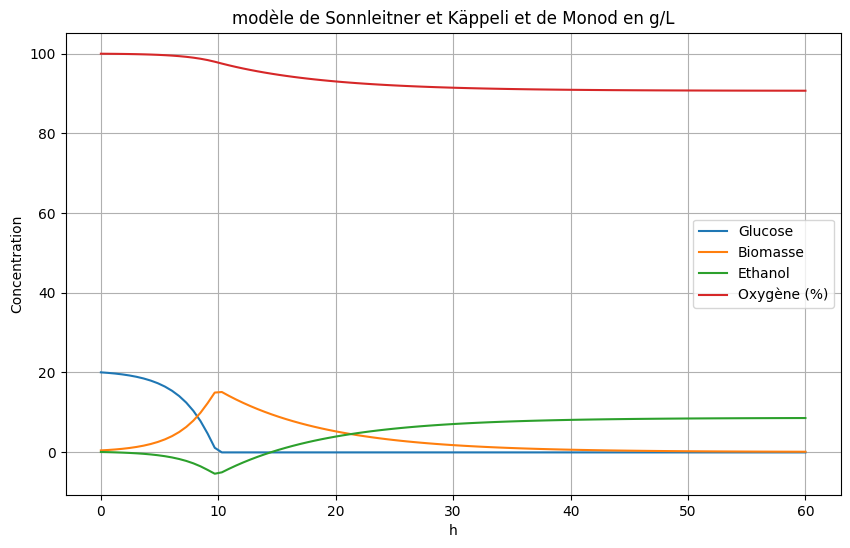

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Paramètres du modèle
mu_max = 0.4  # taux de croissance spécifique maximal (h^-1)
K_s = 0.5  # constante de saturation de Monod pour le glucose (g/L)
Y_E = 0.5  # rendement de l'éthanol sur le glucose (g/g)
q_G = 0.1  # taux spécifique de consommation de glucose (g/g.h)
q_O = 0.05  # taux spécifique de consommation d'oxygène (%/g.h)
m = 0.01  # taux de maintenance (h^-1)

# concentrations initiales
G0 = 20  #  glucose (g/L)
X0 = 0.4  #  biomasse (g/L)
E0 = 0  #  d'éthanol (g/L)
O0 = 100  #  d'oxygène (%)

# equa diff
def model(y, t):
    G, X, E, O = y
    mu = mu_max * (G / (K_s + G))
    dG_dt = -mu * X - q_G * X
    dX_dt = (mu - m) * X
    dE_dt = Y_E * (q_G - mu) * X
    dO_dt = -q_O * X
    return [dG_dt, dX_dt, dE_dt, dO_dt]

# Temps de simulation (heures)
time = np.linspace(0, 60, 100)

# Conditions initiales
y0 = [G0, X0, E0, O0]

# Résoudre les équations différentielles
solution = odeint(model, y0, time)
G, X, E, O = solution.T

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.plot(time, G, label='Glucose')
plt.plot(time, X, label='Biomasse')
plt.plot(time, E, label='Ethanol')
plt.plot(time, O, label='Oxygène (%)')

plt.xlabel('h')
plt.ylabel('Concentration')
plt.title('modèle de Sonnleitner et Käppeli et de Monod en g/L')
plt.legend()
plt.grid(True)
plt.show()

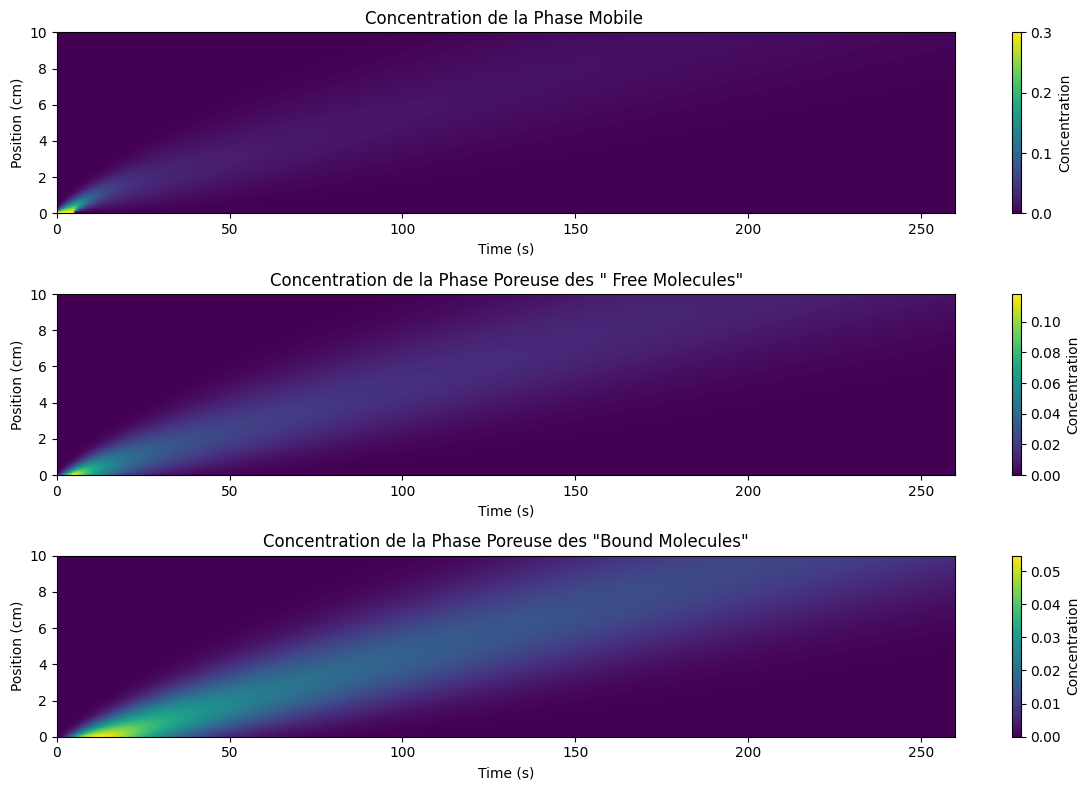

In [ ]:
## In fine, on veut trouver un fenetre de temps tq la concentration en molécule d'intérêt est maximale et d'autre molécules minimale.
## J'ai l'impression qu'on a ici une solution d'une "molécule", qui possède une certaine concentration
## Il faudra peut être additionner les simulations, tweaker les para pour en récupérer la solution la plus pure
class Filtration:
    def __init__(self, feed, filter_size):
        self.feed = feed
        self.filter_size = filter_size

class Chromatography():
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, molecule_size,particle_size,temperature,solvent_viscosity,affinity):

        self.L = L # longueur de la colonne (cm)
        self.T = T # temps de la chromatographie
        self.v = v # velocité linéaire de la phase mobile (m/s)
        self.D = D # coefficient de diffusion  (m^2/s)
        self.Nx = Nx # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration # durée d'alimentation
        self.pulse_concentration = pulse_concentration # concentration de l'alimentation
        self.target_molecule = target_molecule # molécule d'interêt
        self.purified_product = []
        self.particle_size = particle_size
        self.molecule_size = molecule_size
        self.temperature = temperature
        self.solvent_viscosity = solvent_viscosity
        self.affinity = affinity

        self.z = np.linspace(0, L, Nx)

        # Initialize concentration arrays
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        # Initial conditions
        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

        # Transport and production rates -> axe d'amélioration

        self.R = lambda c, cp, q: 0.1 * (c - cp)
        self.Rp = lambda c, cp, q: 0.1 * (c - cp)
        self.Rq = lambda c, cp, q: 0.1 * (cp - q)

        # Store
        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def calculate_diffusion_coefficient(self):
        # Adjusting diffusion coefficient based on temperature and solvent viscosity
        return self.D * (self.temperature / 298.15) * (1.0 / self.solvent_viscosity)

    def calculate_R(self, c, cp, q):
        # Rate term considering particle and molecule sizes and affinity
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rp(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rq(self, c, cp, q):
        return self.affinity * (cp - q) * (self.particle_size / (self.particle_size + self.molecule_size))

    def perform_chromatography(self):
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.R(self.c, self.cp, self.q)
            dcp_dt = self.Rp(self.c, self.cp, self.q)
            dq_dt = self.Rq(self.c, self.cp, self.q)

            self.c += dc_dt * self.dt
            self.cp += dcp_dt * self.dt
            self.q += dq_dt * self.dt

            # Inlet boundary condition
            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0

            # Outlet boundary condition (outflow follows the last grid point)
            self.c[-1] = self.c[-1]

            # Store results
            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def plot_results(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Concentration de la Phase Mobile ')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Concentration de la Phase Poreuse des " Free Molecules"')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 3)
        plt.title('Concentration de la Phase Poreuse des "Bound Molecules"')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.tight_layout()
        plt.show()

# Parameters
L = 10.0
T = 300.0
v = 0.1
D = 0.01
Nx = 100
Nt = 100000
pulse_duration = 5
pulse_concentration = 0.3
target_molecule = 'ARN'
feed = [{'type': 'ARN', 'concentration': 0.2}, {'type': 'Debris', 'concentration': 0.8}]
particle_size = 0.01  # Example particle size
molecule_size = 0.001  # Example molecule size
temperature = 298.15  # Example temperature in Kelvin (25°C)
solvent_viscosity = 1.0  # Example solvent viscosity (arbitrary units)
affinity = 0.1  # Example affinity constant

# Instantiate and run chromatography
chromatography = Chromatography(L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, molecule_size,particle_size,temperature,solvent_viscosity,affinity)
chromatography.perform_chromatography()
chromatography.plot_results()